# Classification

In [1]:
import pandas as pd
import numpy as np
import datetime
import time

%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import transforms # to asjust plot annotations
import seaborn as sns

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.utils import resample # to under-sample majority class
from imblearn.over_sampling import SMOTE # to over-sample minority class


In [2]:
fulldata = pd.read_csv("../data/data_input_for_model.csv")
# fulldata.drop('Unnamed: 0', axis=1, inplace=True)

fulldata = fulldata[fulldata['year'] > 2012]

fulldata.head().T

,1,2,3,4,5
pwsid,CT0010024,CT0010024,CT0010024,CT0010024,CT0010024
pws_name,ANDOVER TOWN HALL & FIRE DEPARTMENT,ANDOVER TOWN HALL & FIRE DEPARTMENT,ANDOVER TOWN HALL & FIRE DEPARTMENT,ANDOVER TOWN HALL & FIRE DEPARTMENT,ANDOVER TOWN HALL & FIRE DEPARTMENT
primacy_agency_code,CT,CT,CT,CT,CT
pws_type_code,TNCWS,TNCWS,TNCWS,TNCWS,TNCWS
gw_sw_code,GW,GW,GW,GW,GW
owner_type_code,P,P,P,P,P
population_served_count,25,25,25,25,25
primary_source_code,GW,GW,GW,GW,GW
is_wholesaler_ind,N,N,N,N,N
is_school_or_daycare_ind,N,N,N,N,N


In [3]:
fulldata.year.unique()

array([2013, 2014, 2015, 2016, 2017])

In [4]:
# select features for modelling
features = ['primacy_agency_code', 'pws_type_code',
           'gw_sw_code', 'owner_type_code', 'population_served_count',
           'primary_source_code', 'is_wholesaler_ind', 'is_school_or_daycare_ind',
           'service_connections_count',
           'year', 
            'had_violation', 'had_violation_lastyear', 
            'had_pesticide_violation', 'had_pesticide_violation_lastyear',
           'EPEST_LOW_KG']
data = fulldata[features]

In [5]:
# get dummies:
# (on the contrary to R, this is needed in python as it is not done automatically by the fitting function)
data = pd.get_dummies(data)

Not many variable seem to be correlated with the outcome (*had_violation* or *had_pesticide_violation*), so the classification task will probably be hard... Only two of them: *pws_type_code*, *year* and especially *had_violation_lastyear*, show some correlation.

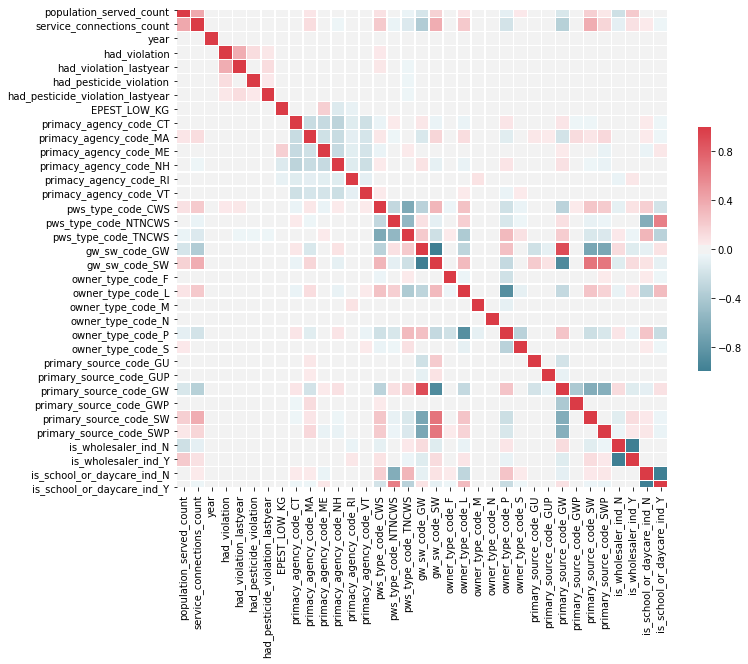

In [6]:
corr = data.corr() 

# heatmap of correlations:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Generate a custom diverging colormap
# Draw the heatmap with the correct aspect ratio:
sns.heatmap(corr, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

We can get rid of some variables that are autocorrelated:

In [7]:
# gw_sw_code_GW and gw_sw_code_SW, as they are highly correlated with primary_source_code and less precise,

# and is_wholesaler_ind_N and is_school_or_daycare_ind_N, as they are binary and thus
# highly correlated with their Y complement,

# service_connections_count as correlated with population_served_count

data.drop(['gw_sw_code_GW', 'gw_sw_code_SW', 'is_wholesaler_ind_N', 'is_school_or_daycare_ind_N',
          'service_connections_count'], 
          axis=1, inplace=True)

## Standardizing the Data

I will do a _0-1 scaling_: 0-1 scaling: (Value - min Value)/(max Value - min Value).


In [8]:
data_std = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
data_std.year.unique()

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

## Training a Model to Classify All Violations (no focus on pesticides)

Using *had_violation* as outcome variable.  



### Splitting in Train, Validation and Test Sets

I use the years 2013 to 2015 as train set, the year 2016 as validation set and the year 2017 as test set.

In [9]:
# SPLITTING IN TRAIN AND TEST:

# let's train to test data on 2013-2017 and predict 2017:
data_train = data_std[data_std.year < 0.75].drop(['had_pesticide_violation', 
                                                 'had_pesticide_violation_lastyear'], axis=1) # 2013, 2014, 2015
data_valid = data_std[data_std.year == 0.75].drop(['had_pesticide_violation', 
                                                  'had_pesticide_violation_lastyear'], axis=1) # 2016
data_test = data_std[data_std.year > 0.75].drop(['had_pesticide_violation', 
                                                'had_pesticide_violation_lastyear'], axis=1) # 2017

X_train = data_train.drop('had_violation', axis=1)
X_valid = data_valid.drop('had_violation', axis=1)
X_test = data_test.drop('had_violation', axis=1)

y_train = data_train.had_violation
y_valid = data_valid.had_violation
y_test = data_test.had_violation


### Handling Class Imbalance

There are largely much water systems that never had any violations of the drinking water. Across all years included, 89% of the water systems never had a violation.  
Thus, it is expected that the baseline performance of any classification algorithm is around 90%.

In [10]:
n = data_std.had_violation.value_counts()
print(n)
print('baseline performance (across years) = percentage of WS without violations: ' + str(n[0]/(n[0]+n[1])) + '%')
print('by year:')
data_std.groupby(['year']).had_violation.value_counts()

0.0    46737
1.0     5618
Name: had_violation, dtype: int64
baseline performance (across years) = percentage of WS without violations: 0.8926941075350969%
by year:


year  had_violation
0.00  0.0              9226
      1.0              1245
0.25  0.0              9292
      1.0              1179
0.50  0.0              9418
      1.0              1053
0.75  0.0              9419
      1.0              1052
1.00  0.0              9382
      1.0              1089
Name: had_violation, dtype: int64

Handling class imbalance has to be done before model selection, as it can have a different influence on the model that we will train after.   

There are several ways of addressing class imbalance that I will try:  

* Over-sampling of minority class; in this case even "synthetic" over-sampling, using SMOTE
* Under-sampling of majority class
* Use another metrics that accuracy to evaluate the model. I will try the Area Under Roc Curve (AUROC); it represents the likelihood of your model distinguishing observations from two classes.
* Penalize the algorithm by increasing the cost of classification mistakes on the minority class, using for instance the argument *class_weight='balanced'* when fitting the logistic regression.

__As the performance of those methods might vary from data set to data set, and from algorithm used to algorithm used, I will first try to use SMOTE while using AUROC as performance metric.__  
If the algorithms would not perform well or generalize well, I would go back the other methods.

#### SMOTE

I will try SMOTE to balance the data. Oversampling has to be done on training data alone ([see comment](https://beckernick.github.io/oversampling-modeling)). Oversampling can lead to bad generalization, that is why we will test the generalizibility on a validation set.

In [11]:
# adapted from this: https://www.kaggle.com/qianchao/smote-with-imbalance-data

print("Number of water systems in X_train dataset: ", X_train.shape)
print("Number of water systems in y_train dataset: ", y_train.shape)
print("Number of water systems in X_valid dataset: ", X_valid.shape)
print("Number of water systems in y_valid dataset: ", y_valid.shape)
print("Number of water systems in X_test dataset: ", X_test.shape)
print("Number of water systems in y_test dataset: ", y_test.shape)

Number of water systems in X_train dataset:  (31413, 27)
Number of water systems in y_train dataset:  (31413,)
Number of water systems in X_valid dataset:  (10471, 27)
Number of water systems in y_valid dataset:  (10471,)
Number of water systems in X_test dataset:  (10471, 27)
Number of water systems in y_test dataset:  (10471,)


In [12]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=51) 
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel()) # oversampling
# SMOTE is about oversampling minority class, BUT while SMOTE still oversamples the minority class, 
# it does not rely on reusing previously existing observations. 
# Instead, SMOTE creates new (synthetic) observations based on the observations in your data.
# see https://towardsdatascience.com/a-deep-dive-into-imbalanced-data-over-sampling-f1167ed74b5

print('After OverSampling, the shape of X_train: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 3477
Before OverSampling, counts of label '0': 27936 

After OverSampling, the shape of X_train: (55872, 27)
After OverSampling, the shape of y_train: (55872,) 

After OverSampling, counts of label '1': 27936
After OverSampling, counts of label '0': 27936


**As from now, we should use *X_train_res* and *y_train_res*, where the minority class (had_violation=1 was over-sampled) to train the models.**

### Training and Model Selection - First Iteration

I will compare **_logistic regression_**, **_gradient boosting_** and **_random forest_** abilitity to classify the water systems that had a violation of drinking water quality.  

The models are trained on the train set, cross-validation with a grid search is used to optimize the parameters. The generalizability of the classifiers is then evaluated on the validation set.  

To evaluate the model, specific attention will be payed to the AUROC, the difference of the AUROC between the train and validation set, the confusion matrices and the precision and recall.


In [13]:
# some functions for model evaluation:

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, shrink =0.5)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color="black" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def model_evaluation(model_name, model, my_X_train, my_y_train, my_X_test, my_y_test):
    # a function that fits the desired models on the train set, 
    # and evaluate them both and train and (validation or test) set.
    
    training_fit = model.fit(my_X_train, my_y_train) # the training. fit is stored and reused below
    
    # evaluation on train set:
    y_pred_train = training_fit.predict(my_X_train)
    y_predproba_train = training_fit.predict_proba(my_X_train)
    Accuracy_train = training_fit.score(my_X_train, my_y_train)
    AUROC_train = roc_auc_score(my_y_train, y_predproba_train[:,1])
    recall_train = recall_score(my_y_train, y_pred_train)
    
    # evaluation on validation set:
    y_pred_valid = training_fit.predict(my_X_test) # predicted y on validation set using model trained on train set
    y_predproba_valid = training_fit.predict_proba(my_X_test)
    Accuracy_valid = training_fit.score(my_X_test, my_y_test)
    AUROC_valid = roc_auc_score(my_y_test, y_predproba_valid[:,1])
    recall_valid = recall_score(my_y_test, y_pred_valid)
    
    # printing results:
    print(model_name)
    print('')
    print("Accuracy on train set: " + str(Accuracy_train))
    print("AUROC on train set: " + str(AUROC_train))
    print("recall on train set: " + str(recall_train))
    print('')
    print("Accuracy on validation set: " + str(Accuracy_valid))
    print("AUROC on validation set: " + str(AUROC_valid))
    print("recall on validation set: " + str(recall_valid))
    print('\n\n')
    
# TO DO HERE:       A FUNCTION TO PLOT ROC CURVES


#### Training the Logistic Regression

I will use a ridge regression, and tune the regularization parameter lambda. 

In [14]:
t0 = time.time()
# find the desired parameter (C = 1/lambda)
logistic = LogisticRegression(solver='liblinear', penalty = 'l2')  
parameters_grid = {'C':[1e-14, 1e-12, 1e-11, 1e-10, 1e-5, 0.01, 0.1, 1, 10]}
logistic_search = GridSearchCV(estimator=logistic, scoring='roc_auc', # SCORE = AUROC and not accuracy !
                               param_grid=parameters_grid, cv=5)
logistic_search.fit(X_train_res, y_train_res) # using the SMOTE resampled training set

print('Best C:',logistic_search.best_estimator_.C)
print('The mean cross-validated score of the best_estimator on X_train:', logistic_search.best_score_)
print('Accuracy on (full) X_train: ' + str(logistic_search.score(X_train_res, y_train_res)))
print('Running time: ' + str(time.time() - t0))

Best C: 1e-14
The mean cross-validated score of the best_estimator on X_train: 0.5072204625433643
Accuracy on (full) X_train: 0.7298277138419562
Running time: 3.4160470962524414


              precision    recall  f1-score   support

         0.0       0.66      0.71      0.68     27936
         1.0       0.69      0.64      0.66     27936

    accuracy                           0.67     55872
   macro avg       0.67      0.67      0.67     55872
weighted avg       0.67      0.67      0.67     55872

AUROC: 0.7298277138419562

Confusion matrix, without normalization
[[19791  8145]
 [10183 17753]]
Normalized confusion matrix
[[0.70844072 0.29155928]
 [0.36451174 0.63548826]]


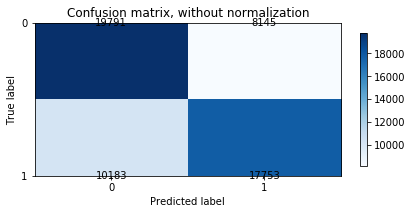

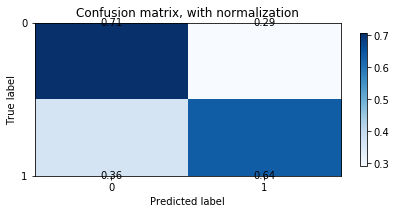

In [15]:
# train chosen model:
logistic_train = LogisticRegression(solver='liblinear', C=1e-14)
logistic_train.fit(X_train_res, y_train_res)

# Evaluating the model on train set:
y_pred = logistic_train.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

y_scores = logistic_train.decision_function(X_train_res)
AUROC = roc_auc_score(y_train_res, y_scores) # store AUROC to compare with the other models
print("AUROC: " + str(AUROC))
print('')

plot_confusion_matrix(y_train_res, y_pred, normalize=False,
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(y_train_res, y_pred, normalize=True,
                      title='Confusion matrix, with normalization')

plt.show()

This is not excessevely brillant... Let's try the other models.

#### Training the Gradient Boosting

I will use _RandomizedSearchCV_ instead of a full grid search with _GridSearchCV_ in order to improve the speed of the parameter tuning. At least in a first step.

In [16]:
# Fix learning rate and number of estimators before tuning tree-based parameters
# first we find right learning rate for the number of estimators

# see this: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

# note: after a first run, I increase the learning rate to 0.2, as the best n_estimators was the upper limit

t0 = time.time()
# define parameters grid:
param_grid = {'n_estimators': range(40,81,20)}

# Initialize and fit the model.
grad_boost = GradientBoostingClassifier(learning_rate=0.2, min_samples_split=500, 
                                        min_samples_leaf=50, max_depth=8, 
                                        max_features='sqrt', subsample=0.8, 
                                        random_state=10)
# min_samples_split good if 05-1% of sample size.
search_grad_boost = RandomizedSearchCV(grad_boost, param_grid, cv=5,
                                scoring='roc_auc') # AND NOT THE ACCURACY!

search_grad_boost.fit(X_train_res, y_train_res)

print("time needed: " + str(time.time() - t0))

print('Best n_estimators:', search_grad_boost.best_estimator_.n_estimators)
print('The mean cross-validated score of the best_estimator on X_train:', search_grad_boost.best_score_)
print('AUROC on (full) X_train: ' + str(search_grad_boost.score(X_train_res, y_train_res)))


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


time needed: 38.77936410903931
Best n_estimators: 80
The mean cross-validated score of the best_estimator on X_train: 0.3585561627071565
AUROC on (full) X_train: 0.86913895794913


I am afraid that the model will not generalize well so I will stick to 80 estimators and not go higher.

In [17]:
### Tuning tree-specific parameters
# The most important first:  max_depth and min_samples_split

t0 = time.time()
# define parameters grid:
param_grid = {'max_depth':range(12,18,3), 
              'min_samples_split':range(100,300,100)
             }

# Initialize and fit the model.
grad_boost = GradientBoostingClassifier(learning_rate=0.2, n_estimators = 100,
                                        min_samples_leaf=50,  
                                        max_features='sqrt', subsample=0.8, 
                                        random_state=10)
search_grad_boost = RandomizedSearchCV(grad_boost, param_grid, cv=5,
                                scoring='roc_auc')

search_grad_boost.fit(X_train_res, y_train_res)

print("time needed: " + str(time.time() - t0))

print('Best max_depth:', search_grad_boost.best_estimator_.max_depth)
print('Best min_samples_split:', search_grad_boost.best_estimator_.min_samples_split)
print('The mean cross-validated score of the best_estimator on X_train:', search_grad_boost.best_score_)
print('AUROC on (full) X_train: ' + str(search_grad_boost.score(X_train_res, y_train_res)))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


time needed: 164.18791389465332
Best max_depth: 15
Best min_samples_split: 100
The mean cross-validated score of the best_estimator on X_train: 0.39840678172279154
AUROC on (full) X_train: 0.9345022401883408


Similarly, to avoid probable overfitting, I will stick with a max depth of 18 for now and not go higher. I will stay with a min_samples_split of 100, not going below as usually it should be around 0.5-1% of the sample size (52355). It is probably an indication of overfitting. If I have more time, I might consider a second iteration of this GridSearchCV.

              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87     27936
         1.0       0.88      0.85      0.87     27936

    accuracy                           0.87     55872
   macro avg       0.87      0.87      0.87     55872
weighted avg       0.87      0.87      0.87     55872

AUROC: 0.9454496152543976

Confusion matrix, without normalization
[[24743  3193]
 [ 4120 23816]]
Normalized confusion matrix
[[0.88570304 0.11429696]
 [0.14747995 0.85252005]]


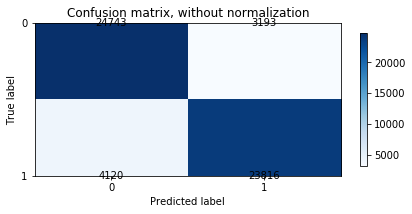

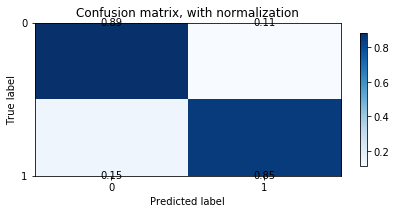

In [18]:
# train chosen model:
grad_boost_train = GradientBoostingClassifier(learning_rate=0.2, n_estimators = 80,
                                        max_depth=18, min_samples_split=100,
                                        min_samples_leaf=30,
                                        max_features='sqrt', subsample=0.8)
grad_boost_train.fit(X_train_res, y_train_res)

# Evaluating the model on train set:
y_pred = grad_boost_train.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

y_scores = grad_boost_train.decision_function(X_train_res)
AUROC = roc_auc_score(y_train_res, y_scores) # store AUROC to compare with the other models
print("AUROC: " + str(AUROC))
print('')

plot_confusion_matrix(y_train_res, y_pred, normalize=False,
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(y_train_res, y_pred, normalize=True,
                      title='Confusion matrix, with normalization')

plt.show()

It already looks much better than the logistic regression, let's hope that the model is not overfitting too much and generalize well.  
We can have a look at the relative importance of the features use by gradient boosting:

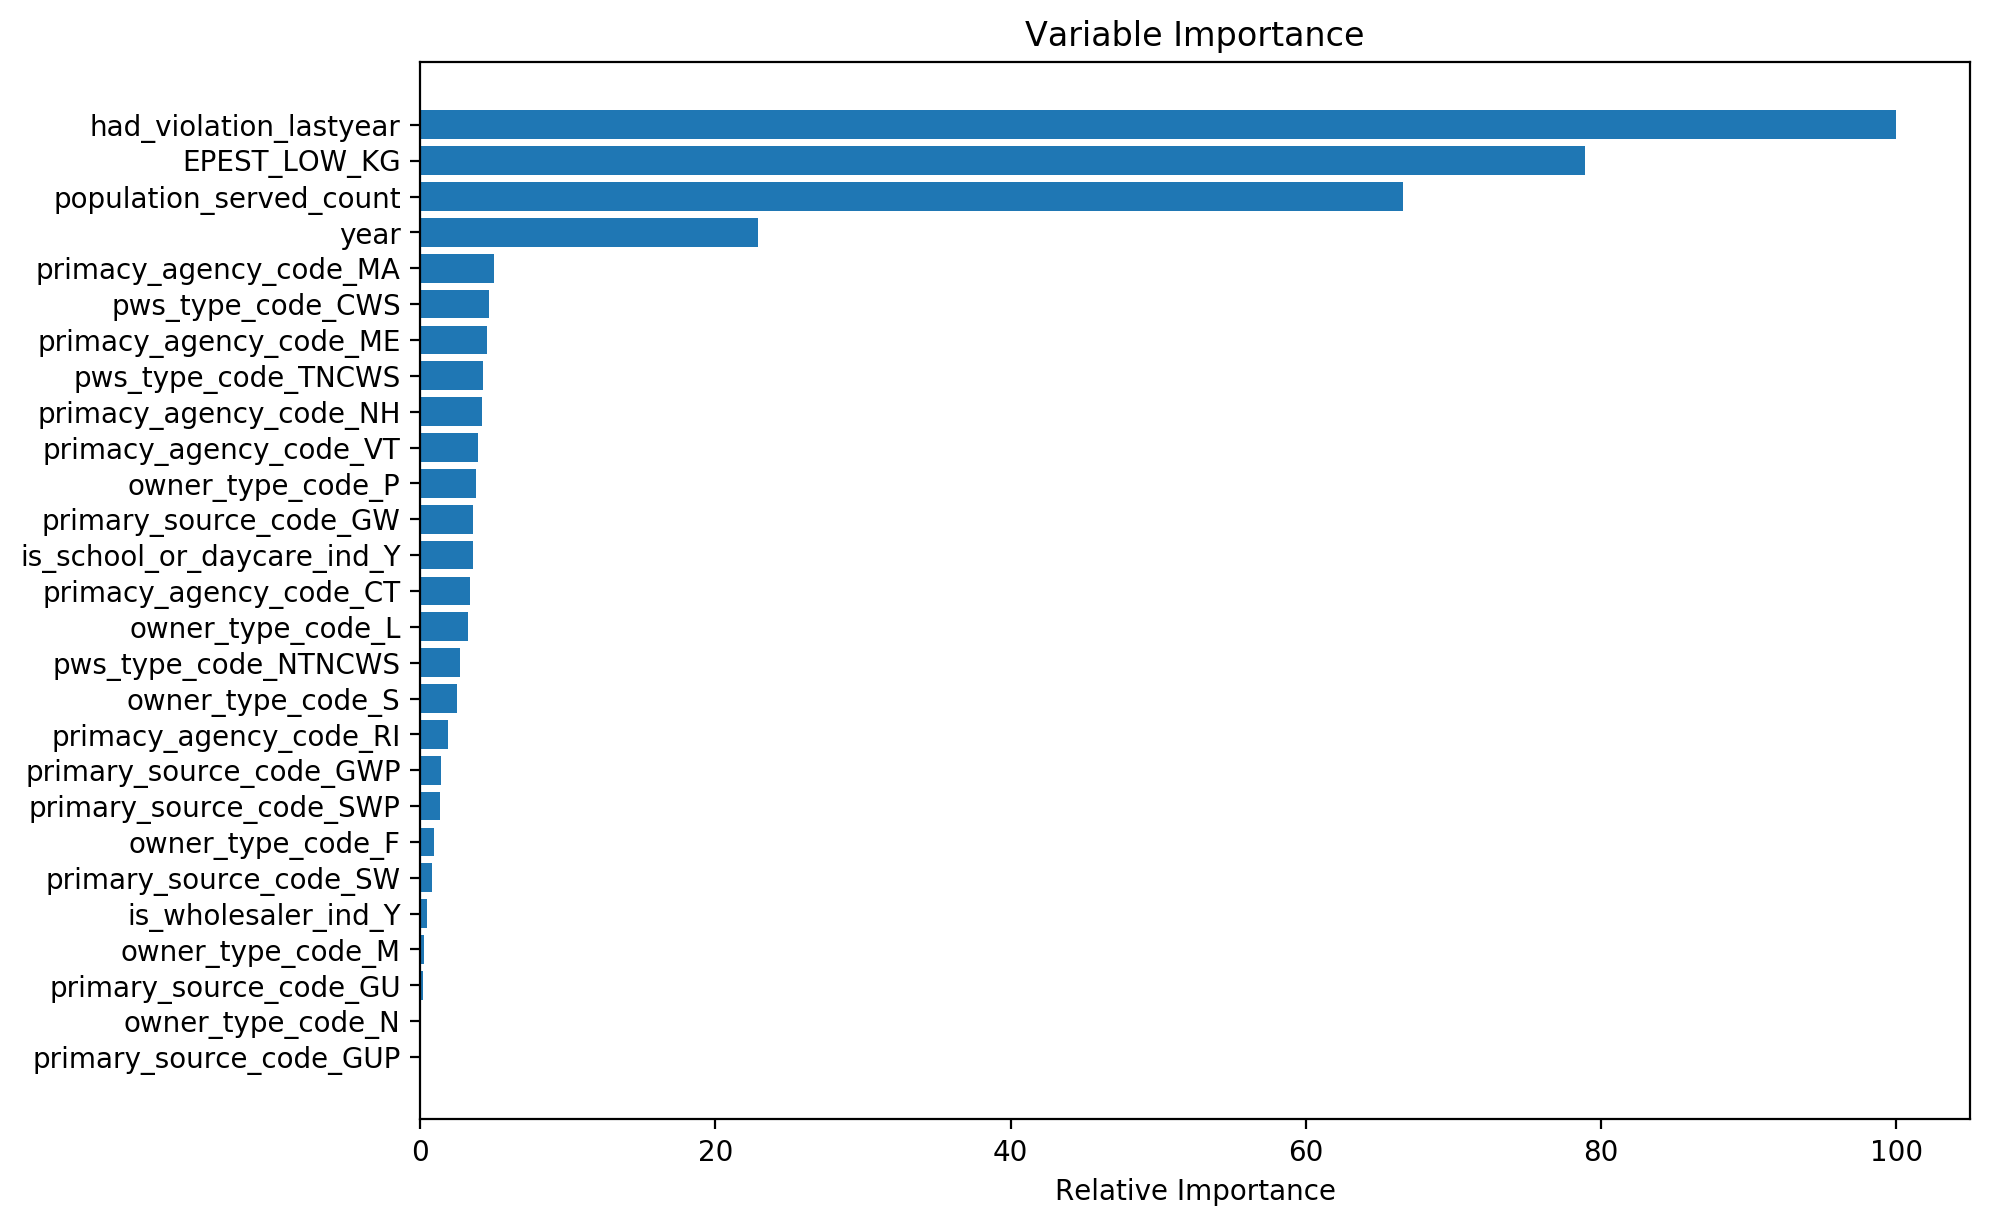

In [19]:
feature_importance = grad_boost_train.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,7), dpi=200)
# plt.figure(num=None, figsize=(4, 4), dpi=200, facecolor='w')
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, data_train.drop('had_violation', axis=1).columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Training the Random Forest
 
Again, I use RandomizedSearchCV instead of GridSearchCV, to gain time.

In [20]:
# Use the randomized grid to search for best hyperparameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 7)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 7)]
# max_depth.append(None) # need to avoid overfitting.
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


t0 = time.time()
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1,
                              scoring='roc_auc')
# Fit the random search model
rf_random.fit(X_train_res, y_train_res)

print("tuned in " + str(time.time() - t0) + 'seconds')

print('best params: ' + str(rf_random.best_params_))
print('The mean cross-validated AUROC of the best_estimator on X_train:', rf_random.best_score_)
print('AUROC on (full) X_train: ' + str(rf_random.score(X_train_res, y_train_res)))

{'n_estimators': [200, 500, 800, 1100, 1400, 1700, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 26, 43, 60, 76, 93, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 47.4min finished


tuned in 2990.2965140342712seconds
best params: {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 93, 'bootstrap': False}
The mean cross-validated AUROC of the best_estimator on X_train: 0.530185258069008
AUROC on (full) X_train: 0.9962922693625766


              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     27936
         1.0       0.98      0.95      0.96     27936

    accuracy                           0.96     55872
   macro avg       0.96      0.96      0.96     55872
weighted avg       0.96      0.96      0.96     55872

AUROC: 0.9962890198306734

Confusion matrix, without normalization
[[27304   632]
 [ 1500 26436]]
Normalized confusion matrix
[[0.97737686 0.02262314]
 [0.05369416 0.94630584]]


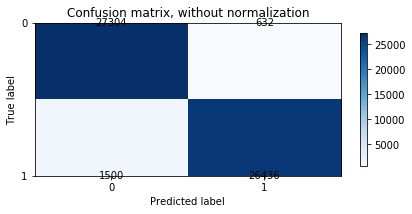

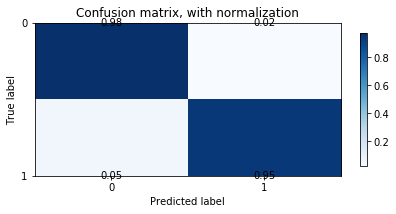

In [21]:
# train chosen model: ! take 5 min
rf_train = RandomForestClassifier(n_estimators=1700, min_samples_split=2, min_samples_leaf=1, 
                            max_features='auto', max_depth=60, bootstrap=False)
rf_train.fit(X_train_res, y_train_res)

y_pred = rf_train.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

y_predproba = rf_train.predict_proba(X_train_res)
AUROC = roc_auc_score(y_train_res, y_predproba[:,1])
print("AUROC: " + str(AUROC))
print('')

plot_confusion_matrix(y_train_res, y_pred, normalize=False,
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(y_train_res, y_pred, normalize=True,
                      title='Confusion matrix, with normalization')

plt.show()

That looks great! But I am afraid that the model overfits...

### Testing the Generalizability of the Classifiers on the Validation Set

I test the generalizability of the 3 trained models on the validation set. The AUROC will be my main criterion to choose a model.   

I will then hopefully pick a favorite model, maybe fine-tune it a bit more, and then finally test it on the test set.

In [22]:
# TAKES 3min.
# Fitting the 3 models and evalutating them on the train and validation set:

# Logistic Regression with Ridge Regularization
log = LogisticRegression(solver='liblinear', C=1e-14, penalty='l2')
model_evaluation("Logistic regression with ridge regularization", log, 
                 X_train_res, y_train_res, X_valid, y_valid)

# Gradient boosting
gb = GradientBoostingClassifier(learning_rate=0.2, n_estimators = 80,
                                        max_depth=18, min_samples_split=100,
                                        min_samples_leaf=30,
                                        max_features='sqrt', subsample=0.8)
model_evaluation("Gradient Boosting", gb, 
                 X_train_res, y_train_res, X_valid, y_valid)

# random forest:
rf = RandomForestClassifier(n_estimators=1700, min_samples_split=2, min_samples_leaf=1, 
                            max_features='auto', max_depth=60, bootstrap=False, n_jobs = -1)
model_evaluation("Random Forest", rf, 
                 X_train_res, y_train_res, X_valid, y_valid)


Logistic regression with ridge regularization

Accuracy on train set: 0.6719644902634594
AUROC on train set: 0.7298644555918766
recall on train set: 0.6354882588774341

Accuracy on validation set: 0.7066182790564416
AUROC on validation set: 0.7009629230133898
recall on validation set: 0.6083650190114068



Gradient Boosting

Accuracy on train set: 0.8681629438717068
AUROC on train set: 0.9456895885725628
recall on train set: 0.8493699885452463

Accuracy on validation set: 0.6820743004488588
AUROC on validation set: 0.6795200886324342
recall on validation set: 0.5484790874524715



Random Forest

Accuracy on train set: 0.9618592497136311
AUROC on train set: 0.996291568458022
recall on train set: 0.9466638029782359

Accuracy on validation set: 0.6754846719511031
AUROC on validation set: 0.6380347424932293
recall on validation set: 0.5066539923954373





There is a large drop in AUROC for the gradient boosting and random forest between the train set and the validation set: **The classifiers are overfitting.**   

I will try to reduce the max_depth and n_estimator in the gradient boosting and random forest, as a first priority. If it is not working sufficiently well, I will try another method to handle class imbalance.  

### New Training Iteration with the Aim to Reduce Overfitting

#### Gradient Boosting


In [23]:
#### Gradient Boosting
# The most important to control for overfitting:  max_depth and n_estimator
# the max parameter values are smaller than before.
# I also try to reduce the learning rate and the subsampling

# Try various values below to get a sense of how the model behaves and generalizes:
# smaller_n_estimators = 20 # instead of 80
# smaller_max_depth = 4 # instead of 18
# smaller_learning_rate = 0.01 # instead of 0.2 
# smaller_subsample=0.6 # instead of 0.8

smaller_n_estimators = 20 # instead of 80
smaller_max_depth = 8 # instead of 18
smaller_learning_rate = 0.075 # instead of 0.2 
smaller_subsample=0.6 # instead of 0.8


gb = GradientBoostingClassifier(n_estimators = smaller_n_estimators,
                                max_depth=smaller_max_depth, 
                                learning_rate=0.2, min_samples_split=100, min_samples_leaf=30,
                                max_features='sqrt', subsample=smaller_subsample, 
                                random_state = 51)

model_evaluation("Gradient Boosting", gb, 
                 X_train_res, y_train_res, X_valid, y_valid)
# WAS PREVIOUSLY (that is want we want to beat):
# Accuracy on validation set: 0.6611593926081558
# AUROC on validation set: 0.6790887543461419
# recall on validation set: 0.5712927756653993

Gradient Boosting

Accuracy on train set: 0.7339096506300115
AUROC on train set: 0.8239636393217635
recall on train set: 0.5877362542955327

Accuracy on validation set: 0.8235125584948907
AUROC on validation set: 0.70857873838859
recall on validation set: 0.5047528517110266





The model is better equilibrated now, as the difference between the training and validation set is smaller.  

Unfortunately, after trying various combination of paramters, it looks like it won't be possible to build a better gradient boosting classifier using the data that we have. Nonetheless, through these iterations used to reduce overfitting, we gain a slightly better area under curve on the validation set. 

#### Random Forest

In [24]:
# Use the randomized grid to search for best hyperparameters

# reducing the grid for parameters useful for overfitting:

higher_n_estimators = 2500 # instead of 1700
smaller_max_depth = 4 # instead of 60
other_min_samples_split = 5 # instead of 2
higher_min_samples_leaf = 50 # instead of 1

# re-evaluating the classifier:
rf = RandomForestClassifier(n_estimators=smaller_n_estimators,
                            max_depth=smaller_max_depth,
                            min_samples_split=other_min_samples_split, 
                            min_samples_leaf=higher_min_samples_leaf, 
                            max_features='auto', bootstrap=False, n_jobs = -1)

model_evaluation("Random Forest", rf, 
                 X_train_res, y_train_res, X_valid, y_valid)
# What we want to beat:
# Accuracy on validation set: 0.6802597650654187
# AUROC on validation set: 0.6397494325239373
# recall on validation set: 0.4990494296577947

Random Forest

Accuracy on train set: 0.6999212485681557
AUROC on train set: 0.7588672018256177
recall on train set: 0.48772193585337914

Accuracy on validation set: 0.8713589915003342
AUROC on validation set: 0.7061928764648109
recall on validation set: 0.43155893536121676





An AUROC of 0.7 on the validation set definitely seems to be the best I can do...

Could it be than the SMOTE is particularly bad in this case for generability? I could try another method for handling class imbalance. 

**Let's try not using SMOTE, but adjusting the class weight in the classifers** (not implemented for _GradientBoostingClassifier_ yet):

In [25]:
# Logistic Regression with Ridge Regularization - adjusting the class weight in the classifier
log = LogisticRegression(solver='liblinear', C=1e-14, penalty='l2',
                        class_weight='balanced')
model_evaluation("Logistic regression with ridge regularization", log, 
                 X_train, y_train, X_valid, y_valid) # NEW: not X_train_res and y_train_res

# Random Forest - adjusting the class weight in the classifier
rf = RandomForestClassifier(n_estimators=2500, min_samples_split=5, max_depth=4, min_samples_leaf=50, 
                            max_features='auto', bootstrap=False, n_jobs = -1,
                           class_weight='balanced') # NEW 

model_evaluation("Random Forest", rf, 
                 X_train, y_train, X_valid, y_valid) # NEW: not X_train_res and y_train_res

Logistic regression with ridge regularization

Accuracy on train set: 0.702002355712603
AUROC on train set: 0.7295544166278747
recall on train set: 0.632729364394593

Accuracy on validation set: 0.7074777958170184
AUROC on validation set: 0.700995318499094
recall on validation set: 0.6083650190114068



Random Forest

Accuracy on train set: 0.836246140133066
AUROC on train set: 0.7483999079122796
recall on train set: 0.5220017256255393

Accuracy on validation set: 0.8407983955687136
AUROC on validation set: 0.705264861857979
recall on validation set: 0.4619771863117871





Conclusion, we arrive at a similar result a lot faster...

Let's quickly **try with undersampling the majority class (_had no violation_)** instead:

In [26]:
# Separate majority and minority classes
df_majority = data_train[data_train.had_violation==0]
df_minority = data_train[data_train.had_violation==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=3477,     # to match minority class
                                 random_state=51) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
print(df_downsampled.had_violation.value_counts())

# New under_sampled majority class train sets:
X_train_down = df_downsampled.drop('had_violation', axis=1)
y_train_down = df_downsampled.had_violation

1.0    3477
0.0    3477
Name: had_violation, dtype: int64


In [27]:
# Logistic Regression with Ridge Regularization - on data where the majority class was undersampled
log = LogisticRegression(solver='liblinear', C=1e-14, penalty='l2')
model_evaluation("Logistic regression with ridge regularization", log, 
                 X_train_down, y_train_down, X_valid, y_valid) # NEW: not X_train_res and y_train_res

# Gradient Boosting - on data where the majority class was undersampled
gb = GradientBoostingClassifier(n_estimators = 20,
                                max_depth=8, 
                                learning_rate=0.075, min_samples_split=700, min_samples_leaf=80,
                                max_features='sqrt', subsample=0.6, 
                                random_state = 51)
model_evaluation("Gradient Boosting", gb, 
                 X_train_down, y_train_down, X_valid, y_valid)

# Random forest - on data where the majority class was undersampled
rf = RandomForestClassifier(n_estimators=2500, min_samples_split=5, max_depth=4, min_samples_leaf=50, 
                            max_features='auto', bootstrap=False, n_jobs = -1)

model_evaluation("Random Forest", rf, 
                 X_train_down, y_train_down, X_valid, y_valid) # NEW: not X_train_res and y_train_res

Logistic regression with ridge regularization

Accuracy on train set: 0.6662352602818522
AUROC on train set: 0.7323732793891309
recall on train set: 0.6471095772217429

Accuracy on validation set: 0.6914334829529176
AUROC on validation set: 0.7020305106941434
recall on validation set: 0.6159695817490495



Gradient Boosting

Accuracy on train set: 0.7001725625539258
AUROC on train set: 0.7523483338350071
recall on train set: 0.5130859936727064

Accuracy on validation set: 0.8402253843949957
AUROC on validation set: 0.7053637639638672
recall on validation set: 0.4600760456273764



Random Forest

Accuracy on train set: 0.6984469370146679
AUROC on train set: 0.7520125473870818
recall on train set: 0.5257405809605982

Accuracy on validation set: 0.8322987298252316
AUROC on validation set: 0.705282472488058
recall on validation set: 0.4667300380228137





Conclusion: the results are very similar (but I did not tune model parameters, however I suppose that it is not worth the investment the time)... 

### Trying if the Models are Better at Classifying Pesticides Violations

The previous outcome variable *had_violation* might be hard to classify or predict because the causes of violations are very diverse and not well explained by the variables in SDWIS. Maybe one could focus the classification on a subset of violations that are better explainable by the available features in SDWIS or other external data added.   

I added one external feature: the estimated pesticide use per county. I will try to classify the water systems that are more likely to see pesticides violations.

In [28]:
data_std_pest = data_std.drop(['had_violation', 'had_violation_lastyear'], axis=1) # remove previous outcome

# let's train to test data on 2013-2017 and predict 2017:
data_pest_train = data_std_pest[data_std_pest.year < 0.75] # 2013, 2014, 2015
data_pest_valid = data_std_pest[data_std_pest.year == 0.75] # 2016
data_pest_test = data_std_pest[data_std_pest.year > 0.75] # 2017

X_pest_train = data_pest_train.drop('had_pesticide_violation', axis=1) # outcome is now had_pesticide_violation
X_pest_valid = data_pest_valid.drop('had_pesticide_violation', axis=1)
X_pest_test = data_pest_test.drop('had_pesticide_violation', axis=1)

y_pest_train = data_pest_train.had_pesticide_violation
y_pest_valid = data_pest_valid.had_pesticide_violation
y_pest_test = data_pest_test.had_pesticide_violation


In [29]:
# Logistic Regression with Ridge Regularization - ON PESTICIDE VIOLATIONS ONLY
log_pest = LogisticRegression(solver='liblinear', C=1e-14, penalty='l2',
                        class_weight='balanced') # handling class imbalance
model_evaluation("Logistic regression with ridge regularization", log_pest, 
                 X_pest_train, y_pest_train, X_pest_valid, y_pest_valid)

# Random Forest - ON PESTICIDE VIOLATIONS ONLY
rf_pest = RandomForestClassifier(n_estimators=2500, min_samples_split=5, max_depth=4, min_samples_leaf=50, 
                            max_features='auto', bootstrap=False, n_jobs = -1,
                           class_weight='balanced') # handling class imbalance
model_evaluation("Random Forest", rf_pest, 
                 X_pest_train, y_pest_train, X_pest_valid, y_pest_valid) 

# no Gradient Boosting for now, as no "class_weight='balanced'" available.

Logistic regression with ridge regularization

Accuracy on train set: 0.5857129214019673
AUROC on train set: 0.8514437992883793
recall on train set: 0.9464285714285714

Accuracy on validation set: 0.5850444083659632
AUROC on validation set: 0.7908515473990527
recall on validation set: 1.0



Random Forest

Accuracy on train set: 0.7139719224524879
AUROC on train set: 0.9238054615282986
recall on train set: 0.9642857142857143

Accuracy on validation set: 0.7068092827810142
AUROC on validation set: 0.8038934556808768
recall on validation set: 0.6666666666666666





This looks quite promising, I will give it a real try. Before, I verify that the lower estimate of pesticide use (average across all pesticides) in kg, per year and county is useful for the classification:

In [30]:
## NO L2 Regularization currently implemented in Statsmodels...

# # from scipy.misc import factorial
from statsmodels.discrete.discrete_model import Logit

# Declare predictors.
X_statsmod = X_pest_train.copy()

# The Statsmodels formulation requires a column with constant value 1 that
# will act as the intercept.
X_statsmod['intercept'] = 1 

# Declare and fit the model.
logit = Logit(y_pest_train, X_statsmod)
result = logit.fit()

# Lots of information about the model and its coefficients, but the
# accuracy rate for predictions is missing.
print(result.summary())


         Current function value: 0.010888
         Iterations: 35
                              Logit Regression Results                             
Dep. Variable:     had_pesticide_violation   No. Observations:                31413
Model:                               Logit   Df Residuals:                    31389
Method:                                MLE   Df Model:                           23
Date:                     Mon, 15 Jul 2019   Pseudo R-squ.:                  0.1666
Time:                             23:13:41   Log-Likelihood:                -342.02
converged:                           False   LL-Null:                       -410.41
Covariance Type:                 nonrobust   LLR p-value:                 3.638e-18
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
population_served_count             -3.1886     18.832     -

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Yes it is. However, a clear issue to this task is the **very large class imbalance**! There is probably not enough data for a classification to perform well (and be evaluated well)

In [31]:
print(y_pest_train.value_counts())
print(y_pest_valid.value_counts())
print(y_pest_test.value_counts())

0.0    31357
1.0       56
Name: had_pesticide_violation, dtype: int64
0.0    10462
1.0        9
Name: had_pesticide_violation, dtype: int64
0.0    10458
1.0       13
Name: had_pesticide_violation, dtype: int64


### Classification of Pestide Violations: Training

Let's try it anyway, despite the too few pesticide violations, just to have a look.

#### Logistic Regression with Ridge Regularization

In [32]:
t0 = time.time()
# find the desired parameter (C = 1/lambda)
logistic = LogisticRegression(solver='liblinear', penalty='l2',
                        class_weight='balanced') # TO COMPENSATE CLASS IMBALANCE
parameters_grid = {'C':[1e-20, 1e-15, 1e-10, 1e-5, 1e-4, 1e-3, 1, 10]}
logistic_search = GridSearchCV(estimator=logistic, scoring='roc_auc', # SCORE = AUROC and not accuracy !
                               param_grid=parameters_grid, cv=3)
logistic_search.fit(X_pest_train, y_pest_train)

print('Best C:',logistic_search.best_estimator_.C)
print('The mean cross-validated score of the best_estimator on X_train:', logistic_search.best_score_)
print('AUROC on (full) X_train: ' + str(logistic_search.score(X_pest_train, y_pest_train)))
print('Running time: ' + str(time.time() - t0))

Best C: 0.0001
The mean cross-validated score of the best_estimator on X_train: 0.7771765639479659
AUROC on (full) X_train: 0.8549381204470179
Running time: 0.9815869331359863


In [33]:
# evaluation on validation set
# Logistic Regression with Ridge Regularization - ON PESTICIDE VIOLATIONS ONLY
log_pest = LogisticRegression(solver='liblinear', C=0.0001, penalty='l2',
                        class_weight='balanced')
model_evaluation("Logistic regression with ridge regularization", log_pest, 
                 X_pest_train, y_pest_train, X_pest_valid, y_pest_valid)


Logistic regression with ridge regularization

Accuracy on train set: 0.6045586222264667
AUROC on train set: 0.8549381204470179
recall on train set: 0.9464285714285714

Accuracy on validation set: 0.6036672715117944
AUROC on validation set: 0.7947439410352811
recall on validation set: 0.8888888888888888





              precision    recall  f1-score   support

         0.0       1.00      0.60      0.75     10462
         1.0       0.00      0.89      0.00         9

    accuracy                           0.60     10471
   macro avg       0.50      0.75      0.38     10471
weighted avg       1.00      0.60      0.75     10471

Confusion matrix, without normalization
[[6313 4149]
 [   1    8]]
Normalized confusion matrix
[[0.60342191 0.39657809]
 [0.11111111 0.88888889]]


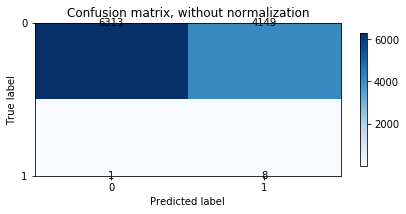

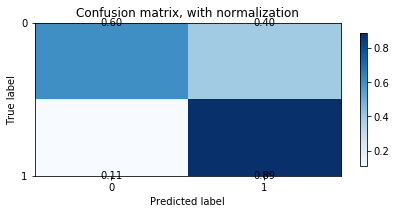

In [34]:
# Evaluating the model on validation set:
y_pred_valid = log_pest.predict(X_pest_valid)
print(classification_report(y_pest_valid, y_pred_valid))

plot_confusion_matrix(y_pest_valid, y_pred_valid, normalize=False,
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(y_pest_valid, y_pred_valid, normalize=True,
                      title='Confusion matrix, with normalization')

#### Gradient Boosting

I first start with a _RandomizedSearchCV_ to locate a good range, then will use _GridSearchCV_ to fine tune.

In [35]:
t0 = time.time()
# define parameters grid:
param_grid = {'n_estimators': range(10,100,10),
              'max_depth':range(12,18,3), 
              'min_samples_split':range(100,300,100)
             }

# Initialize and fit the model. # NOTE: no handling of class imbalance other than using roc_auc:
# Gradient Boosting - on data where the majority class was undersampled
grad_boost = GradientBoostingClassifier(learning_rate=0.075, min_samples_leaf=80,
                                max_features='sqrt', subsample=0.6, 
                                random_state = 51)
search_grad_boost = RandomizedSearchCV(grad_boost, param_grid, cv=3,
                                scoring='roc_auc', n_jobs = -1) # AND NOT THE ACCURACY!

search_grad_boost.fit(X_pest_train, y_pest_train)

print("time needed: " + str(time.time() - t0))

print('Best n_estimators:', search_grad_boost.best_params_)
print('The mean cross-validated score of the best_estimator on X_train:', search_grad_boost.best_score_)
print('AUROC on (full) X_train: ' + str(search_grad_boost.score(X_pest_train, y_pest_train)))

time needed: 8.880827188491821
Best n_estimators: {'n_estimators': 80, 'min_samples_split': 200, 'max_depth': 12}
The mean cross-validated score of the best_estimator on X_train: 0.753934388433388
AUROC on (full) X_train: 0.9979658221677548


In [36]:
# fine tuning:

t0 = time.time()
# define parameters grid:
param_grid = {'n_estimators': range(10,30,5),
              'max_depth':range(12,18, 2), 
              'min_samples_split':range(150, 300, 25)
             }

# Initialize and fit the model. # NOTE: no handling of class imbalance other than using roc_auc:
# Gradient Boosting - on data where the majority class was undersampled
grad_boost = GradientBoostingClassifier(learning_rate=0.075, min_samples_leaf=80,
                                max_features='sqrt', subsample=0.6, 
                                random_state = 51)
search_grad_boost = GridSearchCV(grad_boost, param_grid, cv=3,
                                scoring='roc_auc') # AND NOT THE ACCURACY!

search_grad_boost.fit(X_pest_train, y_pest_train)

print("time needed: " + str(time.time() - t0))

print('Best n_estimators:', search_grad_boost.best_params_)
print('The mean cross-validated score of the best_estimator on X_train:', search_grad_boost.best_score_)
print('AUROC on (full) X_train: ' + str(search_grad_boost.score(X_pest_train, y_pest_train)))

time needed: 53.67517685890198
Best n_estimators: {'max_depth': 14, 'min_samples_split': 200, 'n_estimators': 15}
The mean cross-validated score of the best_estimator on X_train: 0.7680361123661179
AUROC on (full) X_train: 0.9673768445414329


In [37]:
# evaluation on validation set:
gb = GradientBoostingClassifier(n_estimators = 15, max_depth=14, min_samples_split=200,
                                learning_rate=0.075, min_samples_leaf=80,
                                max_features='sqrt', subsample=0.6, 
                                random_state = 51)
model_evaluation("Gradient Boosting", gb, 
                 X_pest_train, y_pest_train, X_pest_valid, y_pest_valid)


Gradient Boosting

Accuracy on train set: 0.9982172985706554
AUROC on train set: 0.9673768445414329
recall on train set: 0.0

Accuracy on validation set: 0.9991404832394232
AUROC on validation set: 0.8331687164128381
recall on validation set: 0.0





              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     10462
         1.0       0.00      0.78      0.00         9

    accuracy                           0.71     10471
   macro avg       0.50      0.74      0.42     10471
weighted avg       1.00      0.71      0.83     10471

Confusion matrix, without normalization
[[7383 3079]
 [   2    7]]
Normalized confusion matrix
[[0.70569681 0.29430319]
 [0.22222222 0.77777778]]


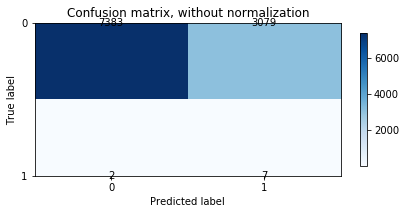

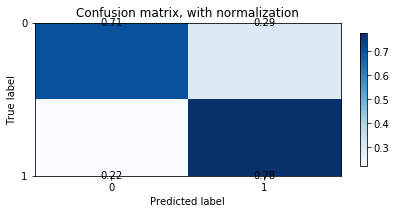

In [38]:
gb = GradientBoostingClassifier(n_estimators = 15, max_depth=14, min_samples_split=200,
                                learning_rate=0.075, min_samples_leaf=80,
                                max_features='sqrt', subsample=0.6, 
                                random_state = 51)
gb.fit(X_pest_train, y_pest_train) # training

# Evaluating the model on validation set:
y_pred_valid = grad_boost_train.predict(X_pest_valid)
print(classification_report(y_pest_valid, y_pred_valid))

plot_confusion_matrix(y_pest_valid, y_pred_valid, normalize=False,
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(y_pest_valid, y_pred_valid, normalize=True,
                      title='Confusion matrix, with normalization')

#### Random Forest

I first start with a _RandomizedSearchCV_ to locate a good range, then will use _GridSearchCV_ to fine tune.

In [39]:
# Use the randomized grid to search for best hyperparameters

# Number of trees in random forest
n_estimators = range(1000, 3000, 500)
# Number of features to consider at every split
max_depth = range(2, 12, 4)
# max_depth.append(None) # need to avoid overfitting.
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 10, 50]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)


t0 = time.time()

# Random Forest - adjusting the class weight in the classifier
rf = RandomForestClassifier(max_features='auto', bootstrap=False, 
                            n_jobs = -1,
                            class_weight='balanced')

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1,
                               scoring='roc_auc')

# Fit the random search model
rf_random.fit(X_pest_train, y_pest_train)

print("tuned in " + str(time.time() - t0) + 'seconds')

print('best params: ' + str(rf_random.best_params_))
print('The mean cross-validated AUROC of the best_estimator on X_train:', rf_random.best_score_)
print('AUROC on (full) X_train: ' + str(rf_random.score(X_pest_train, y_pest_train)))

{'n_estimators': range(1000, 3000, 500), 'max_depth': range(2, 12, 4), 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 10, 50]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   37.1s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   45.1s finished


tuned in 49.2419331073761seconds
best params: {'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 6}
The mean cross-validated AUROC of the best_estimator on X_train: 0.7736151037192941
AUROC on (full) X_train: 0.958231586476476


In [40]:
# Evaluation on validation set
rf = RandomForestClassifier(n_estimators=2000, min_samples_split=10, max_depth=6, min_samples_leaf=10, 
                            max_features='auto', bootstrap=False, n_jobs = -1,
                            class_weight='balanced')

model_evaluation("Random Forest", rf, 
                 X_pest_train, y_pest_train, X_pest_valid, y_pest_valid) 




Random Forest

Accuracy on train set: 0.809155445197848
AUROC on train set: 0.9574548175618112
recall on train set: 0.9821428571428571

Accuracy on validation set: 0.8049851972113456
AUROC on validation set: 0.8088691348584294
recall on validation set: 0.6666666666666666





              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89     10462
         1.0       0.00      0.67      0.01         9

    accuracy                           0.80     10471
   macro avg       0.50      0.74      0.45     10471
weighted avg       1.00      0.80      0.89     10471

Confusion matrix, without normalization
[[8421 2041]
 [   3    6]]
Normalized confusion matrix
[[0.80491302 0.19508698]
 [0.33333333 0.66666667]]


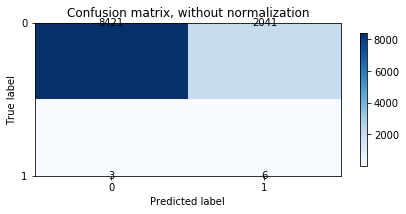

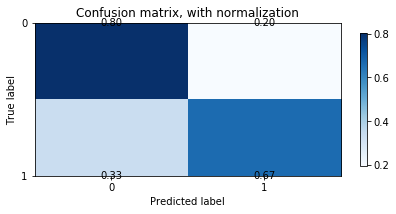

In [41]:
rf.fit(X_pest_train, y_pest_train) # training

# Evaluating the model on validation set:
y_pred_valid = rf.predict(X_pest_valid)
print(classification_report(y_pest_valid, y_pred_valid))

plot_confusion_matrix(y_pest_valid, y_pred_valid, normalize=False,
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(y_pest_valid, y_pred_valid, normalize=True,
                      title='Confusion matrix, with normalization')

### Conclusion

It is quite meaningless to try to classifiy on so few violations by pesticides. However, such a model might be promising for another region in the US, where pesticides contamination is a larger issue, as the estimate of pesticide use seem to be a valuable feature.

## Model Selection

Right below, I re-run the evaluation on the validation set of the models trying to classify water systems that had violations, so the the results are visible.  

I decide to choose the logistic regression, because:

1. It achieves a similar AUROC than the gradient boosting and random forest while having a larger recall. That interest us, as we want to be sure to identify water systems at risk.
2. This while being simpler and faster to run.
3. And it is an explanatory approach.


In [42]:
# Logistic Regression with Ridge Regularization 
log = LogisticRegression(solver='liblinear', C=1e-14, penalty='l2', class_weight='balanced')
model_evaluation("Logistic regression with ridge regularization", log,
                 X_train, y_train, X_valid, y_valid)

# Gradient Boosting - on data where the majority class was undersampled
gb = GradientBoostingClassifier(n_estimators = 20,
                                max_depth=8, 
                                learning_rate=0.075, min_samples_split=700, min_samples_leaf=80,
                                max_features='sqrt', subsample=0.6, 
                                random_state = 51)
model_evaluation("Gradient Boosting", gb, 
                 X_train_down, y_train_down, X_valid, y_valid) # undersampling for the gradient boosting

# Random forest - on data where the majority class was undersampled
rf = RandomForestClassifier(n_estimators=2500, min_samples_split=5, max_depth=4, min_samples_leaf=50, 
                            max_features='auto', bootstrap=False, n_jobs = -1,
                            class_weight='balanced')

model_evaluation("Random Forest", rf, 
                 X_train, y_train, X_valid, y_valid) # NEW: not X_train_res and y_train_res

Logistic regression with ridge regularization

Accuracy on train set: 0.702002355712603
AUROC on train set: 0.7295544166278747
recall on train set: 0.632729364394593

Accuracy on validation set: 0.7074777958170184
AUROC on validation set: 0.700995318499094
recall on validation set: 0.6083650190114068



Gradient Boosting

Accuracy on train set: 0.7001725625539258
AUROC on train set: 0.7523483338350071
recall on train set: 0.5130859936727064

Accuracy on validation set: 0.8402253843949957
AUROC on validation set: 0.7053637639638672
recall on validation set: 0.4600760456273764



Random Forest

Accuracy on train set: 0.8319485563301817
AUROC on train set: 0.7490265302160721
recall on train set: 0.5245901639344263

Accuracy on validation set: 0.8386018527361283
AUROC on validation set: 0.7057066918779572
recall on validation set: 0.46387832699619774





## Testing on Test Set

In [43]:
# Logistic Regression with Ridge Regularization 
log = LogisticRegression(solver='liblinear', C=1e-14, penalty='l2', class_weight='balanced')
model_evaluation("Logistic regression with ridge regularization", log,
                 X_train, y_train, X_test, y_test)
# Read TEST instead of VALIDATION below:

Logistic regression with ridge regularization

Accuracy on train set: 0.702002355712603
AUROC on train set: 0.7295544166278747
recall on train set: 0.632729364394593

Accuracy on validation set: 0.7399484289943654
AUROC on validation set: 0.6712054264863319
recall on validation set: 0.54178145087236





              precision    recall  f1-score   support

         0.0       0.93      0.76      0.84      9382
         1.0       0.21      0.54      0.30      1089

    accuracy                           0.74     10471
   macro avg       0.57      0.65      0.57     10471
weighted avg       0.86      0.74      0.78     10471

Confusion matrix, without normalization
[[7158 2224]
 [ 499  590]]
Normalized confusion matrix
[[0.76295033 0.23704967]
 [0.45821855 0.54178145]]


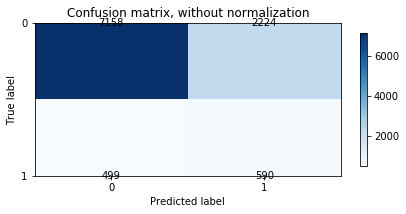

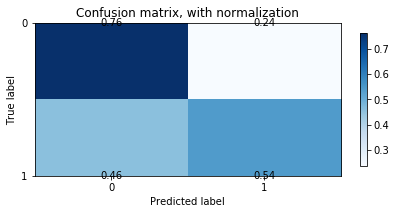

In [44]:
model = log.fit(X_train, y_train) # training

# Evaluating the model on TEST set:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred, normalize=False,
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(y_test, y_pred, normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

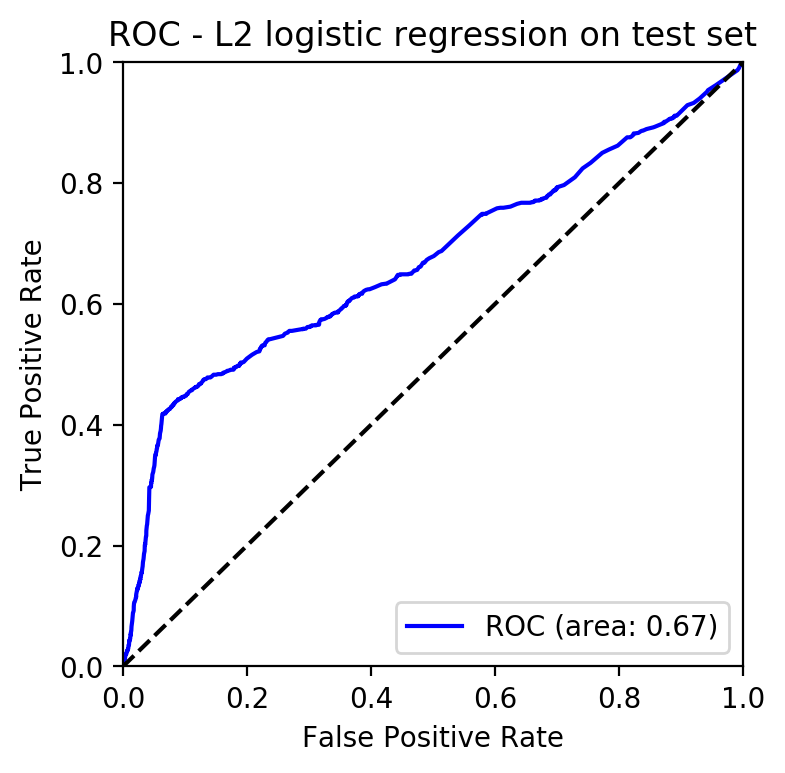

In [45]:
# PLOT ROC:

# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure(num=None, figsize=(4, 4), dpi=200, facecolor='w')
plt.title('ROC - L2 logistic regression on test set')
plt.plot(fpr, tpr, 'b', label = 'ROC (area: ' + str(round(roc_auc, 2)) + ')')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

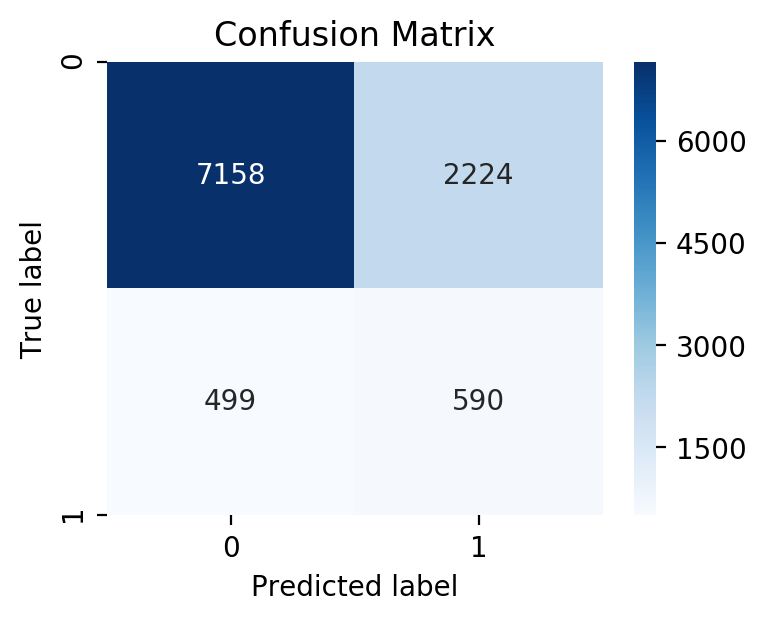

In [48]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# # Show confusion matrix in a separate window
# plt.matshow(cm)
# plt.title('Confusion matrix')
# plt.colorbar()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

plt.figure(figsize = (4,3), dpi=200)
akws = {"ha": 'center',"va": 'center'}
# cmap = sns.palplot(sns.color_palette("Blues")) # Generate a custom diverging colormap
ax = sns.heatmap(cm,  cmap="Blues", annot=True, annot_kws=akws, fmt='')

iteri=0
for t in ax.texts:
    trans = t.get_transform()
    if(iteri > 1): # this is a stupid hack to not get the text on the border of the plot...
        offs = transforms.ScaledTranslation(0, -0.25,
                                            transforms.IdentityTransform())
        t.set_transform( offs + trans )
    else:
        offs = transforms.ScaledTranslation(0, +0.25,
                                            transforms.IdentityTransform())
        t.set_transform( offs + trans )
    iteri=iteri+1
    
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')



plt.show()